In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
path = r'C:/Users/Nick/Documents/Data Science/Personal projects/car-price-prediction/data/raw/'
name = 'data_2024-05-03_15-32.csv'

data_raw = pd.read_csv(path+name)

# 1. Data Cleaning

Drop the errors

In [3]:
n_errors = data_raw[data_raw['Name']=='error'].shape[0]
perc = n_errors / data_raw.shape[0]
data_clean = data_raw[data_raw['Name']!='error'].reset_index(drop=True)
print(f'{perc:.2%} of data removed.')

26.43% of data removed.


Clean the brand name column

In [4]:
# keep only the first word of the name text i.e. brand
data_clean['Name_clean'] = data_clean['Name'].apply(lambda text: text.split()[0])

# remove records of which the brand name is "Αυτοκίνητο"
mask = data_clean[data_clean['Name_clean'] == 'Αυτοκίνητο'].index
perc = len(mask) / data_clean.shape[0]
data_clean = data_clean.drop(mask).reset_index(drop=True)
print(f'Additional {perc:.2%} of data removed.')

# rename some of the brands that were not extracted correctly
conditions = [data_clean['Name_clean']=='Mini',
              data_clean['Name_clean']=='Land',
              data_clean['Name_clean']=='Alfa',
              data_clean['Name_clean']=='Aston',
              data_clean['Name_clean']=='Rolls',
              data_clean['Name_clean']=='Austin']
values = ['Mini-Cooper', 'Land-Rover', 'Alfa-Romeo', 'Aston-Martin', 'Rolls-Royce', 'Austin-Morris']
data_clean['Name_clean'] = np.select(conditions, values, default=data_clean['Name_clean'])

Additional 0.05% of data removed.


Split info to columns and merge to the main dataframe

In [5]:
info_columns = data_clean['Info'].str.split(',', expand=True)
data_clean = pd.merge(data_clean, info_columns, left_index=True, right_index=True)

Clean the splitted columns

In [6]:
# make the first column as datetime
data_clean[0] = pd.to_datetime(data_clean[0], format='%m/%Y')

# keep only records which contain klm info
data_clean = data_clean[data_clean[1].str.contains('χλμ')]
data_clean[1] = data_clean[1].str.replace('.', '',regex=False).str.replace('χλμ', '',regex=False).astype(float)

# keep only records which contain cubic capacity info
data_clean = data_clean[data_clean[2].str.contains('cc')]
data_clean[2] = data_clean[2].str.replace('.', '',regex=False).str.replace('cc', '',regex=False).astype(float)

# clean the horsepower column and make it numeric
data_clean[3] = data_clean[3].str.replace('.', '',regex=False).str.replace('bhp', '',regex=False).astype(float)

# make the gear box column
conditions = [data_clean[4].isin([' Αυτόματο', ' Ημιαυτόματο'])]
values = [data_clean[4]]
data_clean['GearBox'] = np.select(conditions, values, default='Manual')
data_clean['GearBox'] = data_clean['GearBox'].str.strip(' ')

# make the gas type column
conditions = [(data_clean[4] == ' Αυτόματο') | (data_clean[4] == ' Ημιαυτόματο')]
values = [data_clean[5]]
data_clean[4] = np.select(conditions, values, default=data_clean[4])
data_clean[4] = data_clean[4].str.strip(' ')

# drop the unnecessary columns
data_clean.drop(['Info', 5, 6, 7], axis=1, inplace=True)

# rename
data_clean.rename(columns = {
    'Name' : 'FullName',
    'Name_clean' : 'Name',
    0 : 'ProductionDate',
    1 : 'Klm',
    2 : 'CubicCapacity',
    3 : 'Horsepower',
    4 : 'GasType'
}, inplace=True)

# 2. Feature Engineering

In [7]:
data = data_clean.copy()

Make the age attribute

In [8]:
REFERENCE_YEAR = 2024
data['Age'] = REFERENCE_YEAR - data['ProductionDate'].dt.year

## Outliers Halding

Price attribute -  remove records with price less than 800 euros.

In [9]:
data = data[data['Price'] > 800].reset_index(drop=True)

Remove car brands that have less than 20 ads.

In [10]:
counts_df = pd.DataFrame(data['Name'].value_counts())
counts_df.columns = ['count']
counts_df = counts_df[counts_df['count'] >= 20]
name_list = list(counts_df.index)

rows_before = data.shape[0]
data = data[data['Name'].isin(name_list)]
rows_after = data.shape[0]
perc = (rows_before - rows_after) / rows_before
print(f'Additional {perc:.2%} of data removed.')

Additional 0.96% of data removed.


Klm attribute -  an average klm count for a car per year is roughly 10-20k.  
Therefore the dataset filtered for records that have more than 10.000 klm and more than a year age.

In [11]:
mask = data[(data['Klm'] <= 10_000) & (data['Age'] >= 1)].index
perc = len(mask) / data.shape[0]
data = data.drop(mask).reset_index(drop=True)
print(f'Additional {perc:.2%} of data removed.')

Additional 3.32% of data removed.


Horsepower attribute - remove records with horsepower equal to zero.

In [12]:
mask = data[data['Horsepower'] == 0].index
perc = len(mask) / data.shape[0]
data = data.drop(mask).reset_index(drop=True)
print(f'Additional {perc:.2%} of data removed.')

Additional 0.13% of data removed.


# 3. Exploratory Data Analysis

In [13]:
eda_data = data.copy()

# select numerical and categorical attributes
num_cols = eda_data.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
categorical_cols = eda_data.select_dtypes(include=object).columns.drop('FullName')

#### Distribution of target attribute

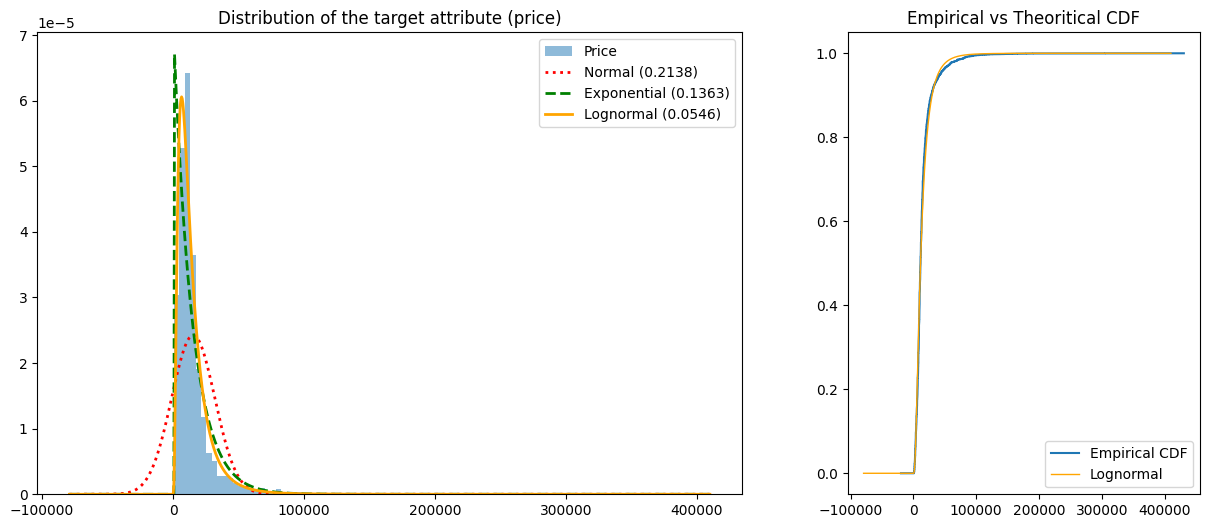

In [50]:
price_values = eda_data['Price'].values

# fit a distribution
loc, scale = stats.norm.fit(price_values)
loc1, scale1 = stats.expon.fit(price_values)
s, loc2, scale2 = stats.lognorm.fit(price_values)

norm_ks = stats.ks_1samp(price_values, stats.norm.cdf, args=(loc, scale)).statistic
expon_ks = stats.ks_1samp(price_values, stats.expon.cdf, args=(loc1, scale1)).statistic
lognorm_ks = stats.ks_1samp(price_values, stats.lognorm.cdf, args=(s, loc2, scale2)).statistic

# calculate the pdfs for plot
x_linspace = np.linspace(start=min(price_values)-80000, stop=max(price_values), num=1000)

norm_pdf = stats.norm.pdf(x_linspace, loc, scale)
expon_pdf = stats.expon.pdf(x_linspace, loc1, scale1)
lognorm_pdf = stats.lognorm.pdf(x_linspace, s, loc2, scale2)

# calculate the empirical cdf from sample and the theoritical choosen one
empirical_cdf = stats.ecdf(price_values).cdf
lognorm_cdf = stats.lognorm.cdf(x_linspace, s, loc2, scale2)

# make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 6), width_ratios=[2,1])

axs[0].hist(price_values, bins=100, density=True, label='Price', alpha=0.5)

axs[0].plot(x_linspace, norm_pdf, lw=2, c='red', ls=':', label=f'Normal ({norm_ks:.4f})')
axs[0].plot(x_linspace, expon_pdf, lw=2, c='green', ls='--', label=f'Exponential ({expon_ks:.4f})')
axs[0].plot(x_linspace, lognorm_pdf, lw=2, c='orange', label=f'Lognormal ({lognorm_ks:.4f})')
axs[0].set_title('Distribution of the target attribute (price)')
axs[0].legend()

empirical_cdf.plot(axs[1], label='Empirical CDF')
axs[1].plot(x_linspace, lognorm_cdf, color='orange', lw=1, label='Lognormal')
axs[1].set_title('Empirical vs Theoritical CDF')
axs[1].legend()

plt.show()

#### Categorical Attributes

In order to determine if each categorical attribute affects the price of cars the [kruskal wallis h test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html) will be used.  
$H_0 : There\ is\ no\ significant\ difference\ between\ the\ groups$

In [15]:
# perform the kw test for a significance level of 5%
sign_level = 0.05
for categorical_col in categorical_cols: 
    groups = [eda_data[eda_data[categorical_col] == g]['Price'] for g in eda_data[categorical_col].unique()]
    stat, p_value = stats.kruskal(*groups)
    if p_value < 0.05:
        print(f'P-value of the test: {p_value:.8%}')
        print(f'Different categories of {categorical_col} attribute affect the price of the car.')

P-value of the test: 0.00000000%
Different categories of Name attribute affect the price of the car.
P-value of the test: 0.00000000%
Different categories of GasType attribute affect the price of the car.
P-value of the test: 0.00000000%
Different categories of GearBox attribute affect the price of the car.


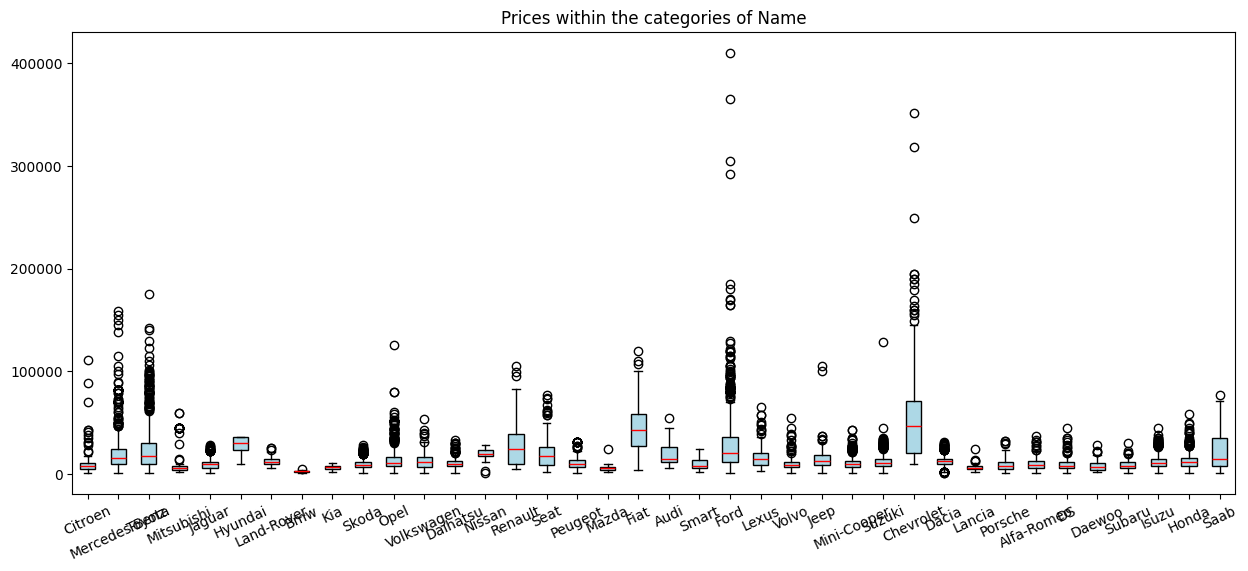

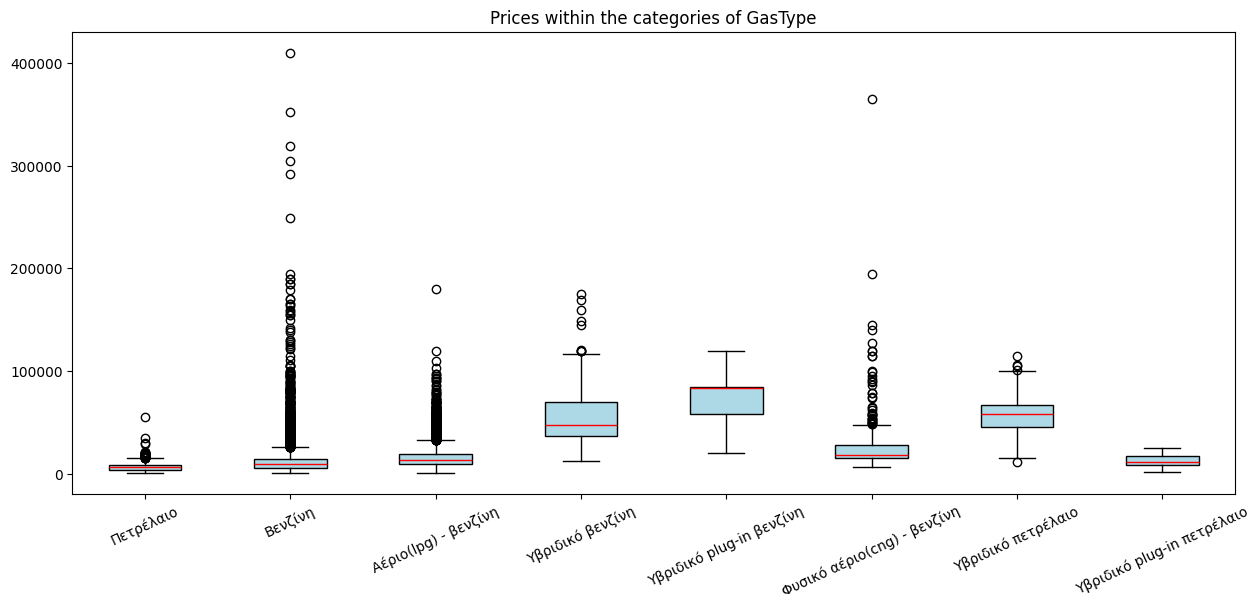

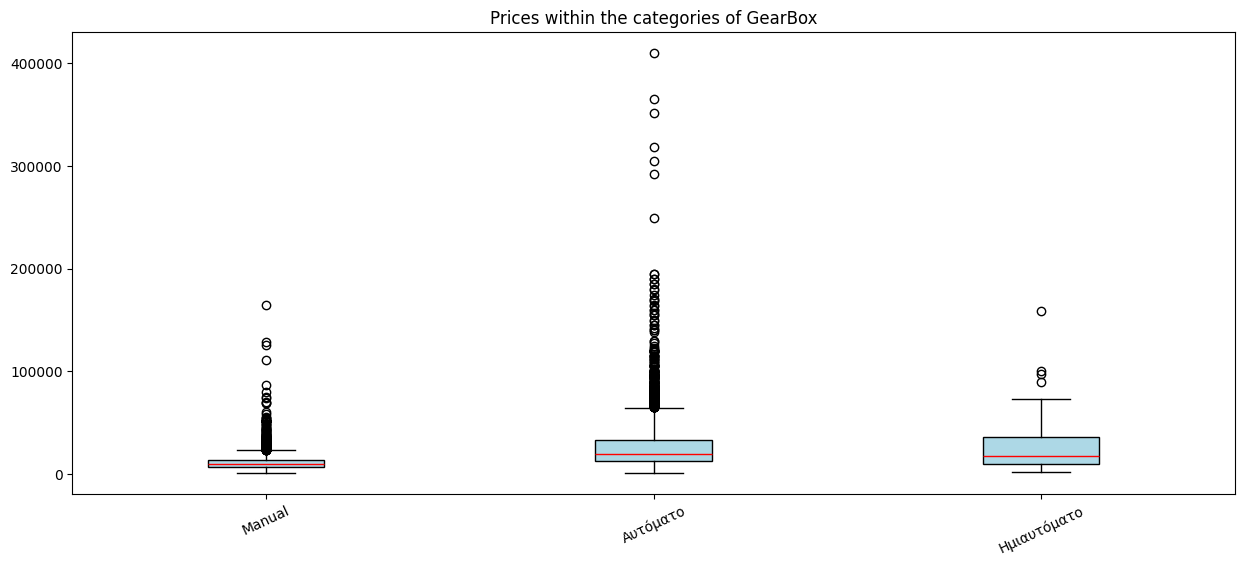

In [16]:
def make_boxplot(categorical_col):
    unique_values = eda_data[categorical_col].unique()
    grouped_data = [group['Price'].values for name, group in eda_data.groupby(categorical_col)]
    plt.figure(figsize=(15, 6))
    box = plt.boxplot(grouped_data, tick_labels=unique_values, patch_artist=True)
    plt.xticks(rotation = 25)
    for patch in box['boxes']:
        patch.set_facecolor('lightblue')
    plt.setp(box['medians'], color='red')
    plt.title(f'Prices within the categories of {categorical_col}')
    plt.show()

for categorical_col in categorical_cols:
    make_boxplot(categorical_col)

#### Numerical Attributes

In [17]:
def num_format(x):
    return f'{x:,.2f}'

eda_data[num_cols].describe().map(num_format)

,Price,Klm,CubicCapacity,Horsepower,Age
count,"17,705.00","17,705.00","17,705.00","17,705.00","17,705.00"
mean,"15,408.01","141,590.75","1,632.12",134.61,11.67
std,"16,452.47","77,266.14",627.72,81.87,7.39
min,810.00,112.00,1.00,1.00,0.00
25%,"7,500.00","91,000.00","1,285.00",90.00,6.00
50%,"11,450.00","133,306.00","1,500.00",112.00,9.00
75%,"17,000.00","180,000.00","1,800.00",150.00,16.00
max,"410,000.00","1,750,000.00","10,000.00","1,111.00",88.00


In [18]:
eda_data.corr(method='pearson', numeric_only=True)

,Price,Klm,CubicCapacity,Horsepower,Age
Price,1.000000,-0.312316,0.417698,0.652445,-0.332800
Klm,-0.312316,1.000000,0.165582,-0.024799,0.447758
CubicCapacity,0.417698,0.165582,1.000000,0.711581,0.204521
Horsepower,0.652445,-0.024799,0.711581,1.000000,-0.002913
Age,-0.332800,0.447758,0.204521,-0.002913,1.000000


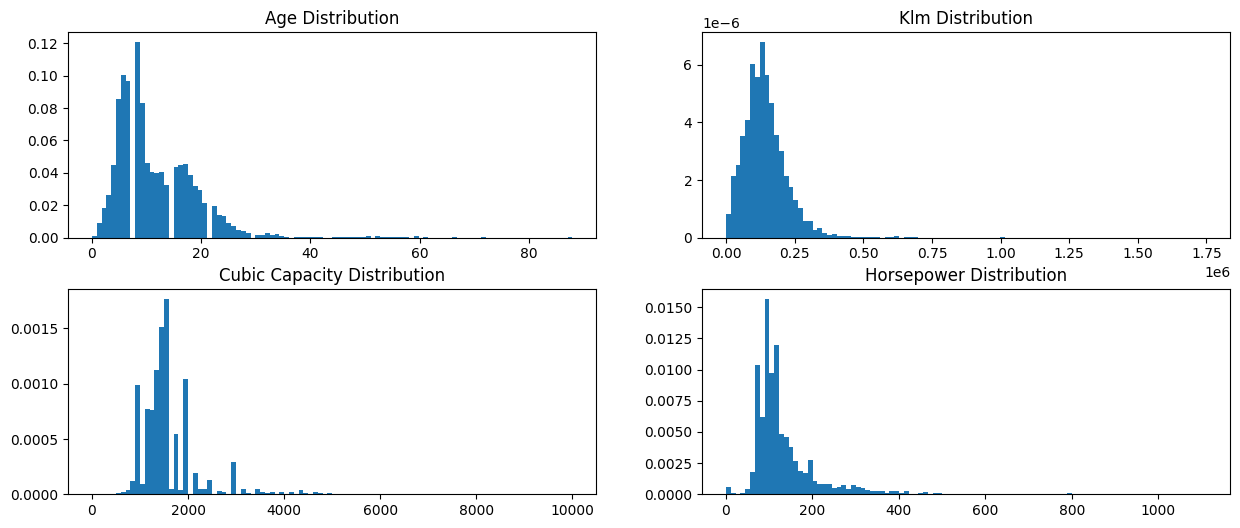

In [19]:
# Check the distributions
fig, axs = plt.subplots(2,2, figsize=(15,6), gridspec_kw={'hspace':.25})
axs[0, 0].hist(eda_data['Age'], bins=100, density=True)
axs[0, 0].title.set_text('Age Distribution')

axs[0, 1].hist(eda_data['Klm'], bins=100, density=True)
axs[0, 1].title.set_text('Klm Distribution')

axs[1, 0].hist(eda_data['CubicCapacity'], bins=100, density=True)
axs[1, 0].title.set_text('Cubic Capacity Distribution')

axs[1, 1].hist(eda_data['Horsepower'], bins=100, density=True)
axs[1, 1].title.set_text('Horsepower Distribution')

plt.show()

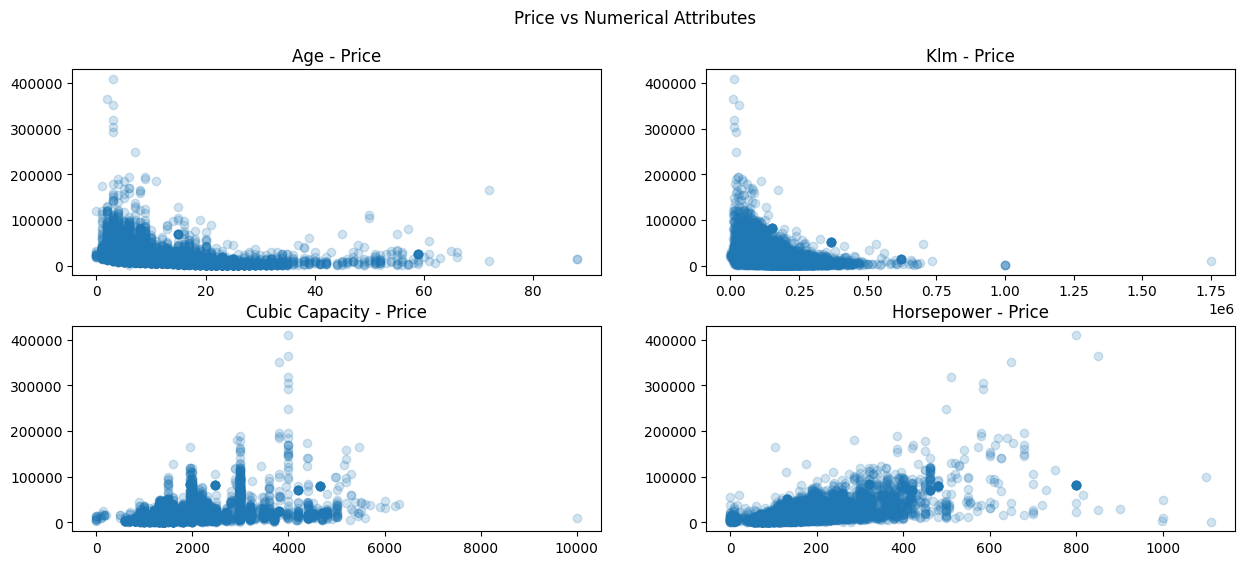

In [20]:
# Price correlations
fig, axs = plt.subplots(2,2, figsize=(15,6), gridspec_kw={'hspace':.25})
axs[0, 0].scatter(x=eda_data['Age'], y=eda_data['Price'], alpha=.2)
axs[0, 0].title.set_text('Age - Price')

axs[0, 1].scatter(x=eda_data['Klm'], y=eda_data['Price'], alpha=.2)
axs[0, 1].title.set_text('Klm - Price')

axs[1, 0].scatter(x=eda_data['CubicCapacity'], y=eda_data['Price'], alpha=.2)
axs[1, 0].title.set_text('Cubic Capacity - Price')

axs[1, 1].scatter(x=eda_data['Horsepower'], y=eda_data['Price'], alpha=.2)
axs[1, 1].title.set_text('Horsepower - Price')

plt.suptitle('Price vs Numerical Attributes')
plt.show()


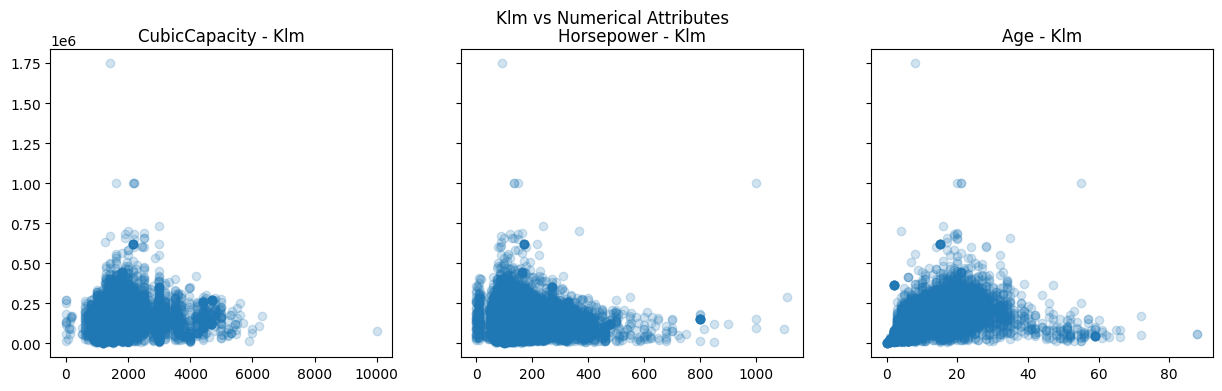

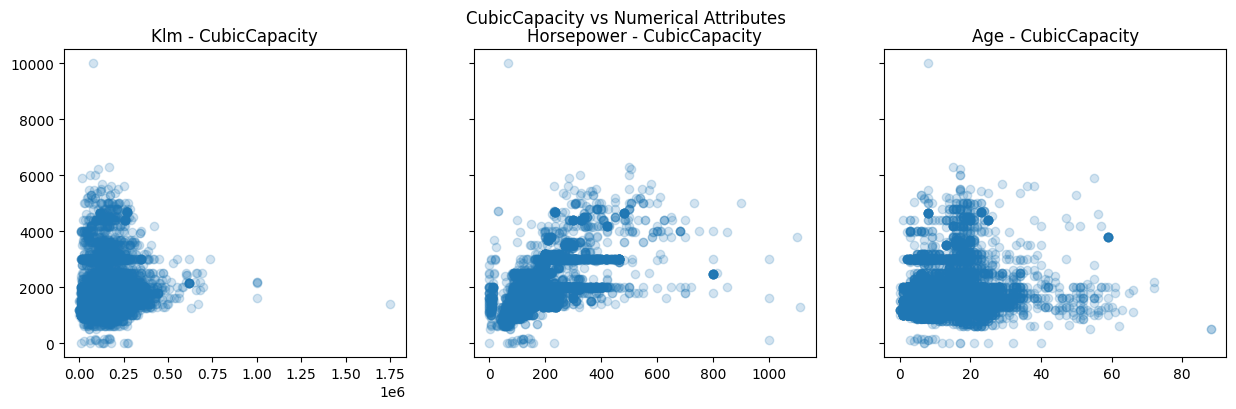

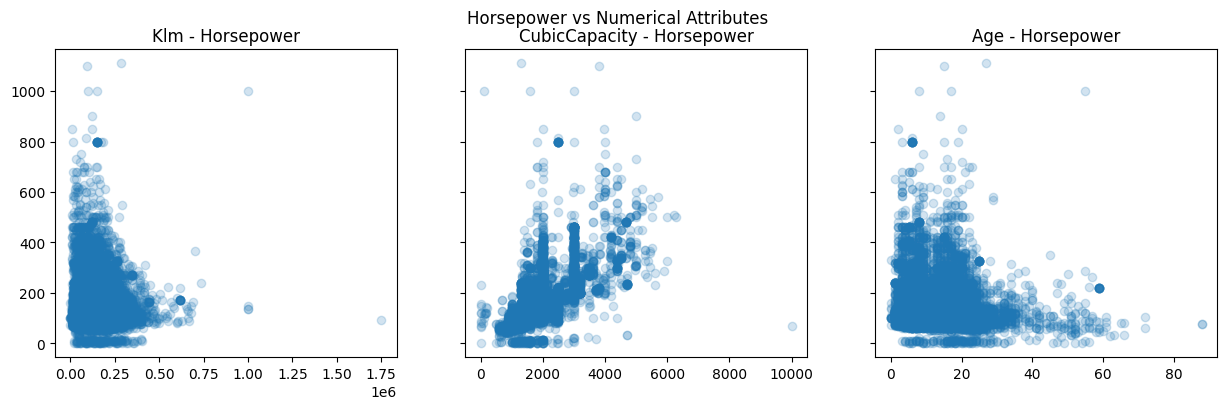

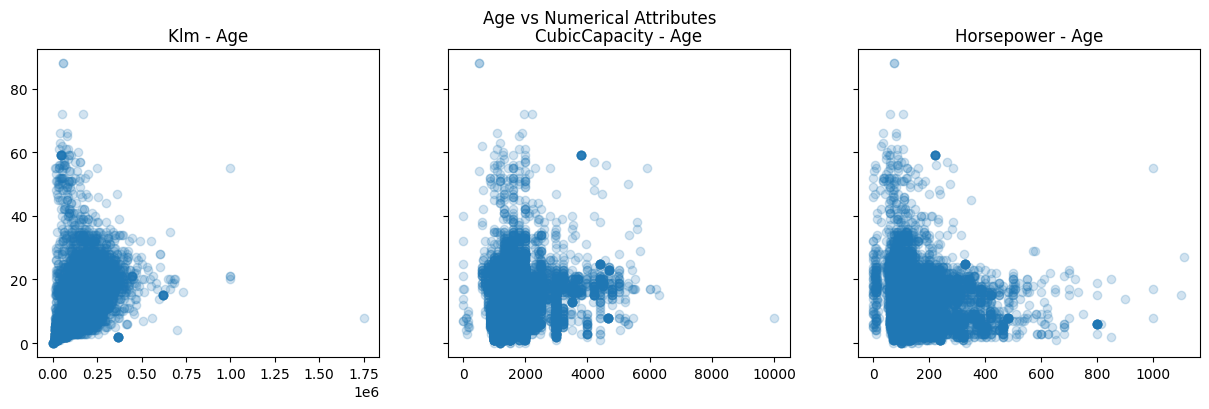

In [21]:
# Other numerical attributes correlations
for col in num_cols.drop('Price'):
    remaining_num_cols = num_cols.drop(['Price', col])
    fig, axs = plt.subplots(1,3, figsize=(15,4), sharey=True)
    for i in range(3):
        axs[i].scatter(x=eda_data[remaining_num_cols[i]], y=eda_data[col], alpha=.2)
        axs[i].title.set_text(f'{remaining_num_cols[i]} - {col}')
    plt.suptitle(f'{col} vs Numerical Attributes')
    plt.show()

# 4. Save Data

In [23]:
perc = (data_raw.shape[0] - eda_data.shape[0]) / data_raw.shape[0]
print(f'{perc:.2%} of raw data was removed, either from incorrect scraping or from the cleaning process.')

31.63% of raw data was removed, either from incorrect scraping or from the cleaning process.


In [ ]:
save_path = r'C:/Users/Nick/Documents/Data Science/Personal projects/car-price-prediction/data/clean/'
file_name = 'data_clean_20240811.csv'

eda_data.to_csv(save_path+file_name, sep=';', index=False)
print('Data Saved')

Data Saved
